# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0)

In [3]:
bandit0.get_num_arms()

3

In [4]:
bandit0.get_reward(arm=0)

1.8255111545554434

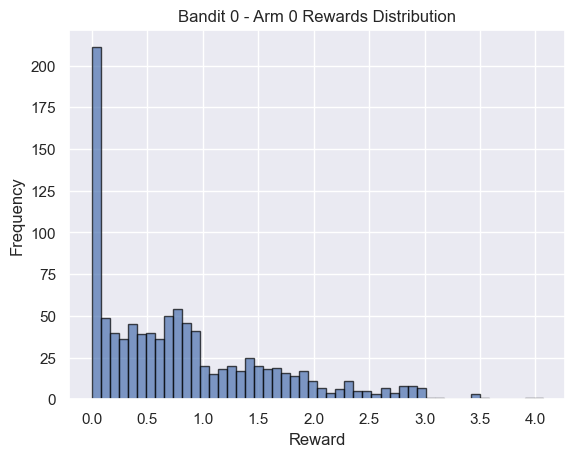

Arm 0 - Mean: 0.81, Std: 0.78


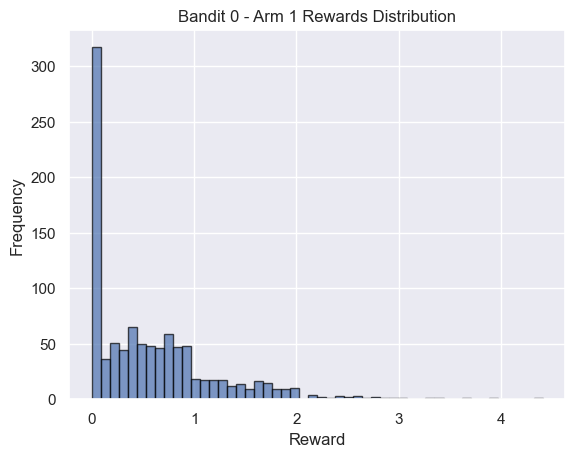

Arm 1 - Mean: 0.57, Std: 0.63


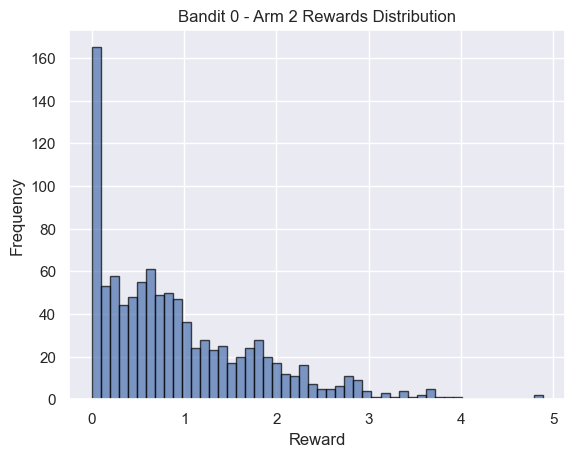

Arm 2 - Mean: 0.93, Std: 0.85


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# Vizualize the results for each arm
for arm in range(bandit0.get_num_arms()):
    in_rewards = []
    for i in range(1000):
        in_rewards.append(bandit0.get_reward(arm=arm))

    plt.hist(in_rewards, bins=50, edgecolor='black', alpha=0.7)
    plt.title(f"Bandit 0 - Arm {arm} Rewards Distribution")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.show()

    # display the mean and std of each arm
    print(f"Arm {arm} - Mean: {np.mean(in_rewards):.2f}, Std: {np.std(in_rewards):.2f}")

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

In [6]:
with open('submission/algorithm-choice.txt', 'w') as f:
    f.write('The Epsilon Greedy is more suitable for this problem because it balances exploration and exploitation effectively, allowing the agent to discover the best arm while still leveraging known information to maximize rewards.')
    f.write('The UCB algorithm may not perform well as it requires more initial exploration to find the optimal arm.')
    f.write('The Thompson Sampling Approach can be computationally intensive although this dataset is small, with the environment allowing multiple possible rewards, it may not fit well.')

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [18]:
# ...existing code...
# Upper Confidence Bound (UCB1) implementation and run
import math
import pandas as pd

def run_ucb(bandit, T=1000):
    """
    UCB1 for a stationary K-armed bandit.
    
    Args:
        bandit: an instance of BanditProblem
        T: total number of pulls

    Returns: (history_df, arm_averages, arm_counts)
    """
    K = bandit.get_num_arms()
    arm_counts   = [0 for _ in range(K)]
    arm_totals   = [0.0 for _ in range(K)]
    arm_averages = [0.0 for _ in range(K)]
    chosen_averages = []

    rows = []
    # Initialize: pull each arm once
    for a in range(K):
        r = float(bandit.get_reward(a))
        arm_counts[a] += 1
        arm_totals[a] += r
        arm_averages[a] = arm_totals[a] / arm_counts[a]
        chosen_averages.append(arm_averages[a])
        rows.append({"action": a, "reward": r})

    arm_averages_history = []
    ucb_history = []

    # Main loop (t = total pulls so far)
    for t in range(K+1, T+1):
        ucb = [arm_averages[j] + math.sqrt(2 * math.log(t) / arm_counts[j]) for j in range(K)]
        a = int(np.argmax(ucb))
        r = float(bandit.get_reward(a))
        arm_totals[a] += r
        arm_counts[a] += 1
        arm_averages[a] += (r - arm_averages[a]) / arm_counts[a]  # correct incremental mean

        chosen_averages.append(arm_averages[a])
        arm_averages_history.append(arm_averages.copy())
        ucb_history.append(ucb)
        rows.append({"action": a, "reward": r})

    history_df = pd.DataFrame(rows, columns=["action", "reward"])
    return history_df, arm_averages, arm_counts

Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [19]:
# Run the UCB algorithm on the bandit problem
bandit_actual = BanditProblem(2025002)
history_df, arm_mean_est, arm_pulled = run_ucb(bandit_actual)
history_df.to_csv("submission/history.tsv", sep="\t", index=False)

In [20]:
history_df.head()

,action,reward
0,0,1.575207
1,1,0.000000
2,2,0.000000
3,0,1.804006
4,0,0.432083


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [21]:
# Summary of the results
print("Pull counts per arm:", dict(enumerate(arm_pulled)))
print("Estimated means per arm:", dict(enumerate(np.round(arm_mean_est, 4))))
print("Average reward:", history_df['reward'].mean())

Pull counts per arm: {0: 619, 1: 311, 2: 70}
Estimated means per arm: {0: np.float64(0.5676), 1: np.float64(0.4971), 2: np.float64(0.2606)}
Average reward: 0.5241579211232674


In [22]:
# Calculate the mean, min, and max reward for each arm from the history_df
arm_stats = history_df.groupby('action')['reward'].agg(['mean', 'min', 'max'])

# Save the results to a TSV file
arm_stats.to_csv("submission/actions.tsv", sep="\t")

arm_stats

,mean,min,max
action,,,
0,0.567559,0.0,3.761461
1,0.497100,0.0,2.707422
2,0.260578,0.0,0.982414


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [23]:
len(history_df)

1000

In [24]:
# Regret Estimates for Different Strategies
T = len(history_df)
arm_means = arm_stats['mean']
mu_star = arm_means.max()
K = history_df['action'].nunique()

# uniform: each arm 1/K of the time
uniform_regret = T * (mu_star - arm_means.mean())

# just-i: always pick arm i
just_rows = [(f"just-{int(i)}", T * (mu_star - mu_i)) for i, mu_i in arm_means.items()]

# actual: use your actual action counts with empirical μ_i
counts = history_df['action'].value_counts().reindex(arm_means.index, fill_value=0)
expected_total_reward_actual = (counts * arm_means).sum()
actual_regret = T * mu_star - expected_total_reward_actual

rows = [("uniform", uniform_regret)] + just_rows + [("actual", actual_regret)]
strategies_df = pd.DataFrame(rows, columns=["strategy", "regret"])
strategies_df.to_csv("submission/strategies.tsv", sep="\t", index=False)
strategies_df


,strategy,regret
0,uniform,125.813554
1,just-0,0.000000
2,just-1,70.459136
3,just-2,306.981527
4,actual,43.401498


Write your results to a file "strategies.tsv" with the columns strategy and regret.

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

In [ ]:
with open('submission/acknowledgements.txt', 'w') as f:
    f.write('Acknowledgements:\n')
    f.write('I would like to acknowledge the resources from Blackboard and the professors example code that helped guid my understanding and acted as a template for further code imporevements.\n')
    f.write('I would also like to acknowledge the discussions from Piazza as they were helpful in diagnosing errors from the autograder.\n')
    f.write("Finally I'd like to acknowledge ChatGPT as it was helpful in debugging some of my code syntax and assisting with code improvements and explanations.\n")

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.